`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   

# Лабораторная работа №3,4. Парсинг сайтов и анализ текстовой информации
*Данные*: раздел "детское" на сайте [irecommend.ru/catalog/list/9](https://irecommend.ru/catalog/list/9)

### Загрузка пакетов

In [3]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
import pymorphy2
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [4]:
nltk.download('stopwords')

True

### Загрузка и проверка данных

In [5]:
products_info = []

for page_num in range(0, 30):
    url = f'https://irecommend.ru/catalog/list/9?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    products = soup.find_all('div', class_='ProductTizer plate teaser-item')
    
    for product in products:
        title = product.find('div', class_='title').text
        counter = product.find('span', class_='counter').text
        products_info.append((title, counter))
        
    sleep(randint(8, 11))

In [6]:
df = pd.DataFrame(products_info, columns=['title', 'counter'])

In [7]:
df.head()

,title,counter
0,Скакалка Sport&Fun Арт. EPYK-1066,2
1,Подгузники-трусики Pikool Classic,38
2,Толстовка Futurino Fashion,1
3,Солнцезащитный крем Мое солнышко Водостойкий s...,14
4,Платье UNUSHUAL трикотажное с карманами (арт:7...,2


### Первичный анализ данных

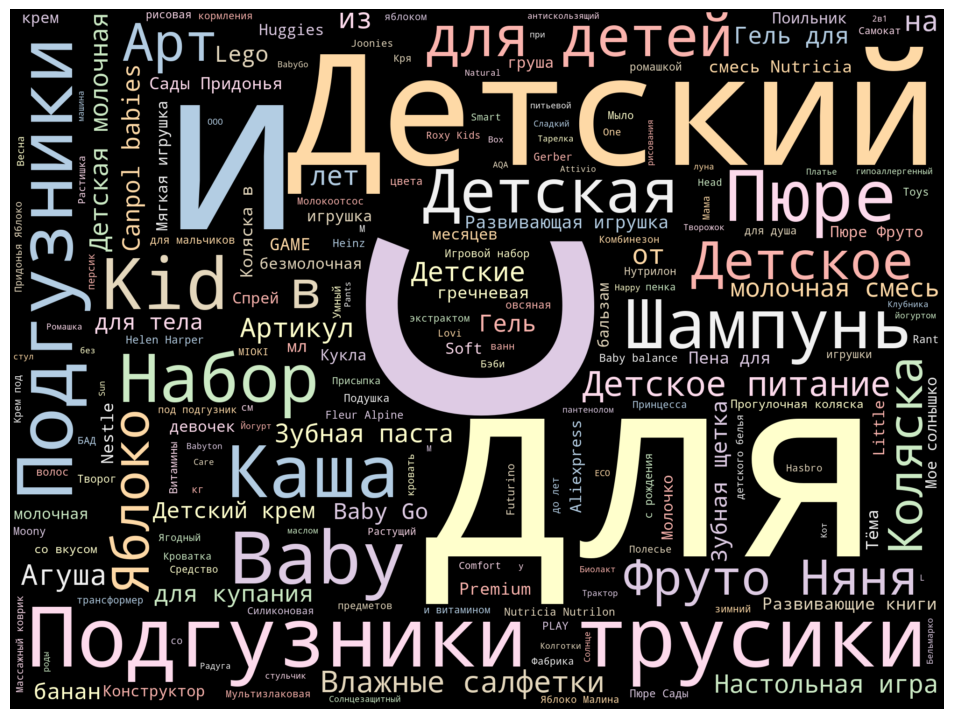

In [8]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Можно заметить насколько часто используется слово "с" или поменьше "для" в названиях товаров. Необходимо привести данные к нижнему регистру, почистить от стоп-слов, знаков препинания, одиночных чисел и символов, а также привести к нормальной форме.

### Обработка данных

In [9]:
morph = pymorphy2.MorphAnalyzer()
stop_words = stopwords.words("russian")

def clean_title_lemmatize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\b\d+\b', '', title)
    title = re.sub(r'\b\w{1,2}\b', '', title)
    words = word_tokenize(title)
    words = [word for word in words if word not in stop_words]
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return ' '.join(lemmas)

In [12]:
df['title'] = df['title'].apply(clean_title_lemmatize)

In [13]:
df.head()

,title,counter
0,скакалка sportfun арт epyk1066,2
1,подгузникитрусик pikool classic,38
2,толстовка futurino fashion,1
3,солнцезащитный крем солнышко водостойкий spf30...,14
4,платье unushual трикотажный карман арт70161194,2


### Анализ после обработки

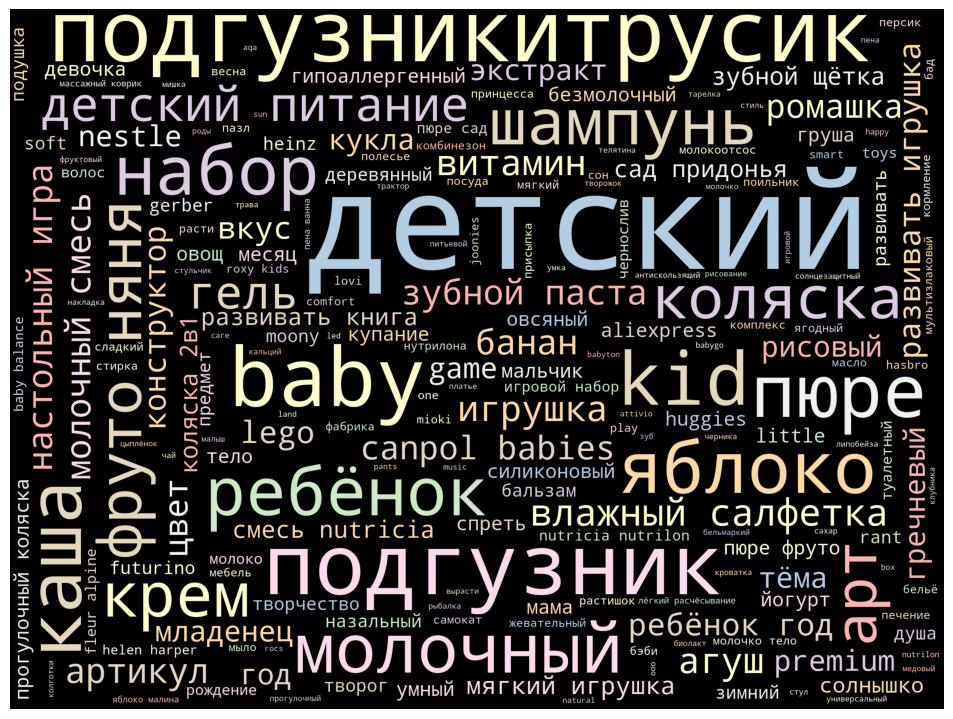

In [14]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Нам удалось обработать текст и выделить наиболее часто встречающиеся темы, которые относятся к разделу "детское".

### Частотный анализ слов

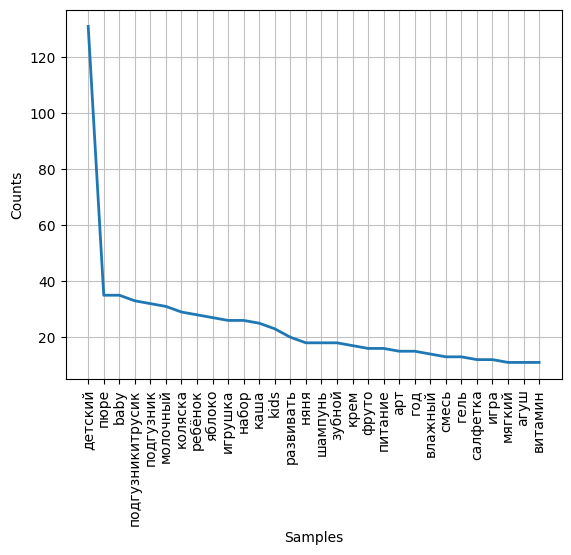

In [15]:
fdist = FreqDist()

for title in df['title']:
    for word in title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Скорее всего, разделение может быть произведено по:

* Детское питание
* Игрушки
* Коляски
* Подгузники
* Детская одежда
* Товары детской гигиены

### Разделение с помощью TfidVectorizer и CountVectorizer

In [16]:
titles = df['title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[tfidf_clusters == i])
    print()

Cluster 1:
38     набор детский творчество genio kids умный песо...
74     ооо фабрика игрушка набор опыт вулкан кинетиче...
86            стром игровой набор стоматолог предмет арт
144                               полесье песочный набор
157    набор разноцветный мелок рисование fix price s...
158    поильникнепроливайка canpol babies lovesea мяг...
170                       маникюрный набор canpol babies
171                     набор игровой attivio блеск губа
186                      playdoh игровой набор ветеринар
207         пустышка lovi силиконовый динамический folky
217         набор опыт школа талант вырасти свой питомец
223      игровой набор стром парикмахер предмет арт у818
240    набор детский творчество amu toys набор юный х...
286                              набор посуда росигрушка
297    ndplay исследовательский набор извержение вулк...
348                      анданте набор магнит овощ фрукт
382    набор детский посуда hppy kds силиконовый предмет
387               пе

In [17]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[count_clusters == i])
    print()

Cluster 1:
68     комплекс экстракт купание малыш здравландия со...
381    натуральный комплекс экстракт трава наш мама к...
Name: title, dtype: object

Cluster 2:
254    весы maman sbbc216
261    весы maman sbbc216
Name: title, dtype: object

Cluster 3:
0                         скакалка sportfun арт epyk1066
1                        подгузникитрусик pikool classic
2                             толстовка futurino fashion
3      солнцезащитный крем солнышко водостойкий spf30...
4         платье unushual трикотажный карман арт70161194
                             ...                        
595              пюре агуш мягкий упаковка яблоко персик
596             кукла paola reina горджусс мечтательница
597                       подгузникитрусик pampers pants
598                  пена купание baby balance воздушный
599    солнцезащитный спреть vichy ideal soleil ребён...
Name: title, Length: 502, dtype: object

Cluster 4:
27                        подгузник joonies premium soft
39       

TfidfVectorizer в большинстве случаях всегда будет давать более хорошие результаты, так как он учитывает не только частоту слов, но и их важность в тексте. Примерные его группы разбиения:

1) Детские наборы для творчества и игровые наборы

2) Детское питание

3) Средства гигиены для детей

4) Разнообразные товары для детей и семьи

5) Коляски

6) Детское пюре

7) Брендовые игрушки

8) Пазлы, игры и обучающие товары

9) Зубные щётки и пасты

10) Подгузники

### Визуализация разбиения

In [18]:
def make_cooccurrence_matrix(texts):
  # Зададим словарь и попарную частоту совместной встречаемости слов
  vocabulary = set(texts[0].split())
  for t in texts[1:]:
    vocabulary = vocabulary.union(set(t.split()))
  vocabulary=list(vocabulary)

  N = len(vocabulary)
  
  # Задаём cooccurrence matrix
  cooccurrence = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      if i == j:
        continue
      for t in texts:
        if vocabulary[i] in t.split() and vocabulary[j] in t.split():
          cooccurrence[i][j]+=1
          cooccurrence[j][i]+=1
  return cooccurrence, vocabulary

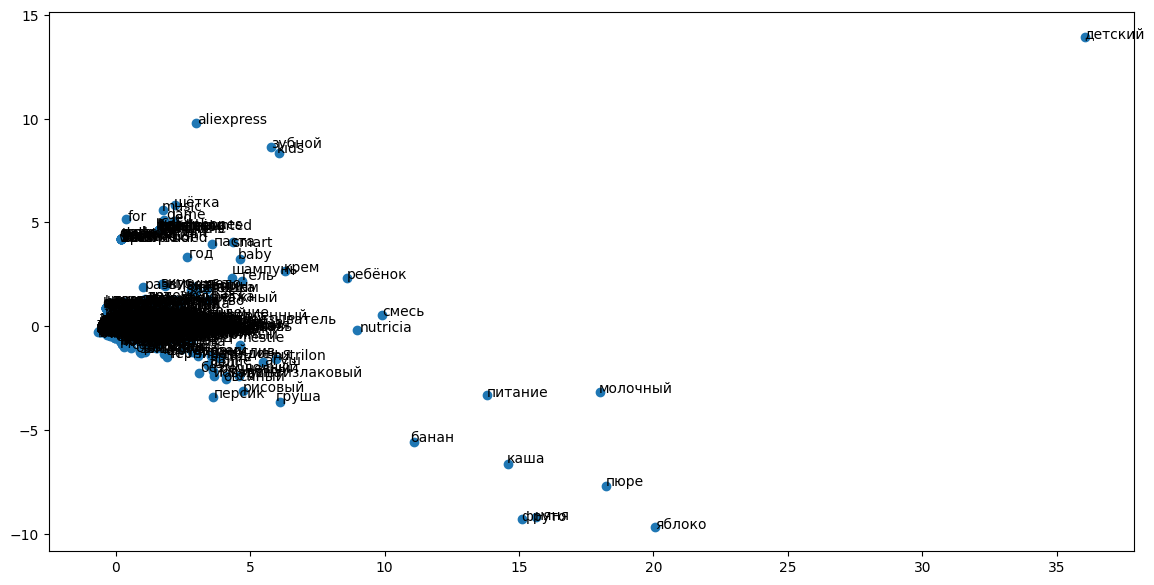

In [20]:
text_list = df['title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

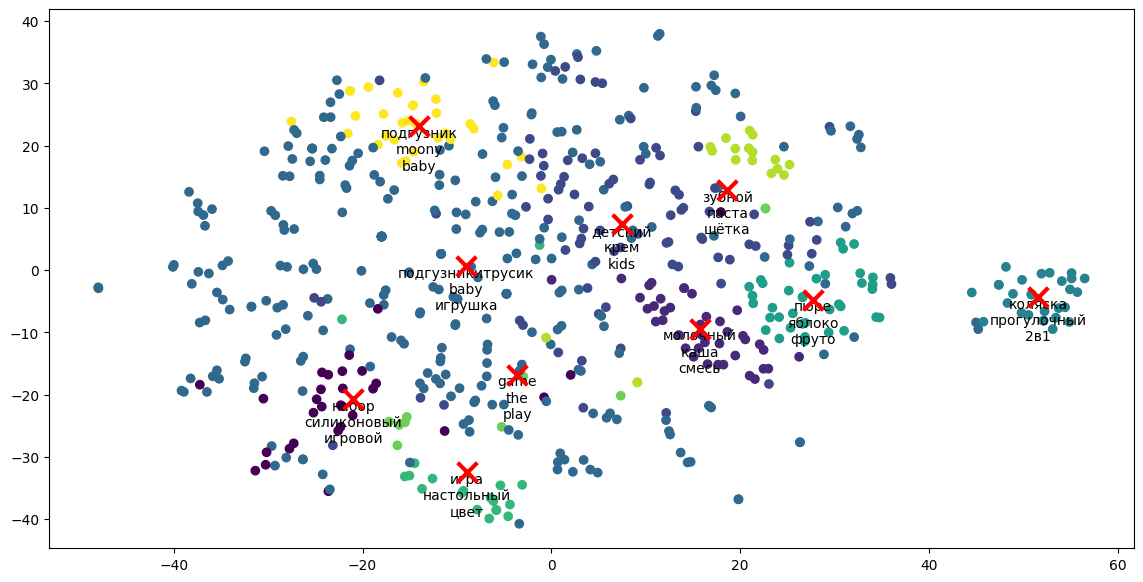

In [21]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((n_clusters, 2))
for i in range(n_clusters):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(n_clusters):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

### Подсчёт характеристик

In [22]:
df['counter'] = df['counter'].astype(int)
df['cluster'] = tfidf_clusters

In [23]:
title_count = df.groupby('cluster')['title'].count()

sum_counts = df.groupby('cluster')['counter'].sum()

stats_df = pd.concat([title_count, sum_counts], axis=1)
stats_df.columns = ['title_count', 'sum_counts']

stats_df

,title_count,sum_counts
cluster,,
0,30,158
1,40,1729
2,87,2875
3,298,16388
4,29,385
5,37,1056
6,19,180
7,10,98
8,18,473


Исходя из таблицы, можно сделать вывод, что товары из 3-го кластера (разнообразные товары для детей и семьи) наиболее популярны и пользуются наибольшей популярностью среди пользователей. Этот кластер имеет значительно больше отзывов, чем остальные кластеры.

Кластеры 1 (детское питание), 2 (средства гигиены для детей) и 5 (детское пюре) также имеют довольно большое количество отзывов, что свидетельствует о высоком спросе на товары данных категорий. Особенно стоит обратить внимание на 9-й кластер (подгузники), который, хотя и имеет меньшее число заголовков, обладает значительным количеством отзывов. Это может говорить о том, что товары из этой категории вызывают большой интерес у потребителей и имеют высокий потенциал для продаж.

Кластеры 0 (детские наборы для творчества и игровые наборы), 4 (коляски), 6 (брендовые игрушки) и 8 (зубные щётки и пасты) имеют меньшее количество отзывов, что может говорить о более узкой аудитории потребителей или о низкой популярности данных товаров на рынке. Кластер 7 (пазлы, игры и обучающие товары), имеющий наименьшее количество отзывов, может свидетельствовать о том, что товары из этой категории пользуются минимальной популярностью среди пользователей и, возможно, имеют очень узкую целевую аудиторию.